<a href="https://colab.research.google.com/github/shauryasrivastava-1612/AI-Powered-Phishing-detection-and-Mitigation/blob/main/AI_Powered_Phishing_Detection_And_Mitigation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Step 1: Installing Required Dependencies**
Before proceeding, we need to install all the required libraries that will help in building the phishing detection model.  
These include:

#### **Core Libraries**
- `pandas` – For data manipulation and handling.
- `numpy` – For numerical computations.
- `scikit-learn` – For machine learning algorithms and model evaluation.

#### **Natural Language Processing (NLP)**
- `nltk` – For text preprocessing, tokenization, and stopword removal.
- `spacy` – For advanced NLP processing.
- `textblob` – For text analysis and sentiment detection.
- `swifter`– To speed up the performance of operations on pandas DataFrames by applying functions in parallel.

#### **Web Scraping & Parsing**
- `beautifulsoup4` – To extract text from HTML-based emails.
- `lxml` – A fast parser for handling structured documents.

#### **Feature Engineering & Vectorization**
- `tqdm` – For displaying progress bars when processing data.
- `wordcloud` – For visualizing word frequency.
- `tensorflow` & `keras` – If deep learning models are required for classification.

The following command installs all required packages:


In [73]:
# Install any missing packages (if required)
!pip install pandas numpy scikit-learn nltk spacy beautifulsoup4 requests swifter

### **Step 2: Importing Required Libraries**
Now that all dependencies are installed, we need to import them into our project.  
This step ensures that the necessary tools for **data preprocessing, machine learning, and NLP** are available.

#### **Key Imports:**
- `pandas` & `numpy` → Handling data and numerical operations.
- `nltk` & `spacy` → Text preprocessing for phishing email detection.
- `beautifulsoup4` → Extracting text from HTML-based emails.
- `sklearn.feature_extraction.text.TfidfVectorizer` → Converting text data into numerical format.
- `sklearn.model_selection.train_test_split` → Splitting data into training and testing sets.
- `sklearn.ensemble.RandomForestClassifier` → A machine learning model for classification.
- `tqdm` → Displaying progress bars during data processing.

The following code imports these libraries:


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
# For text processing
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# For machine learning later
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import swifter
from sklearn.ensemble import IsolationForest

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Step 3: Loading the Dataset**
To train our AI-powered phishing detection model, we need a dataset containing both **legitimate** and **phishing** emails.

#### **Dataset Requirements**
- The dataset should have labeled email samples:
  - `spam` (1) → Indicates a phishing or malicious email.
  - `not-spam` (0) → Indicates a legitimate email.
- The dataset should contain features such as **email text, sender information, and embedded links**.

#### **Loading the Data**
The dataset is typically stored in a **CSV file** and can be loaded using `pandas`. We will:
1. Read the dataset into a DataFrame.
2. Display the first few rows to understand the structure.


In [3]:
# Load the dataset
df_sample = pd.read_csv('/content/drive/MyDrive/a/dataset.csv')
# print(df.head())
print(df_sample.head())

                                               email  category
0  URL: http://www.newsisfree.com/click/-1,817167...  not-spam
1  On Thu, 19 Sep 2002, Bill Stoddard wrote:\n\n-...  not-spam
2  Dan Kohn <dan@dankohn.com> writes:\n\n\n\n> Gu...  not-spam
3  wintermute wrote:\n\n>>Anyone know where in Ir...  not-spam
4  I attended the same conference, and was impres...  not-spam


### **Step 4: Exploring and Cleaning the Dataset**
Before training our phishing detection model, we need to clean the data to remove any inconsistencies and irrelevant information.  
This step ensures that our dataset is structured and usable for machine learning.

#### **Key Data Exploration Tasks**
1. **Checking Dataset Structure**  
   - Print the column names to understand available features.  
   - Check for missing or null values.  
   - Display basic statistics of numerical features.

2. **Handling Missing Data**  
   - Emails with missing text are removed since they do not contribute to training.  
   - Any redundant or irrelevant columns (like email metadata) are dropped.

3. **Checking Class Distribution**  
   - Analyze the distribution of phishing (spam) vs. non-phishing (not-spam) emails to detect class imbalance.


In [4]:
# Check for null values and data types
print(df_sample.info())
print(df_sample.describe())
# Print a sample email subject and body
print("Subject Example:", df_sample['email'].iloc[0])

print("Body Example:", df_sample['category'].iloc[0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3796 entries, 0 to 3795
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   email     3796 non-null   object
 1   category  3796 non-null   object
dtypes: object(2)
memory usage: 59.4+ KB
None
                                                    email  category
count                                                3796      3796
unique                                               3654         2
top     \n\nHello I am your hot lil horny toy.\n\n    ...  not-spam
freq                                                    7      1900
Subject Example: URL: http://www.newsisfree.com/click/-1,8171676,1440/

Date: Not supplied



Detailed guidelines for vaccinating all 288 million citizens within five days 

of an outbreak are being dispatched to every state





Body Example: not-spam


### **Step 5: Text Cleaning Function**
In this step, we define a text cleaning function that processes email text to remove unnecessary content and prepare it for further analysis. This function helps standardize the text, remove noise, and ensure that we are working with meaningful tokens.

#### **Text Cleaning Process:**
1. **Remove HTML Tags**: We use `BeautifulSoup` to extract only the raw text from HTML-based emails, removing all tags and metadata.
2. **Remove Non-Alphabetical Characters**: The text is stripped of anything that is not a letter (such as numbers and special characters). This helps the model focus on the actual words in the emails.
3. **Convert to Lowercase**: The text is converted to lowercase to ensure uniformity and avoid treating the same word in different cases as different tokens.
4. **Tokenization**: We split the cleaned text into individual words (tokens).
5. **Stopword Removal**: We use a predefined set of stopwords to filter out common but meaningless words (e.g., "the", "and", "in") that don't contribute to distinguishing phishing from legitimate emails.

The following code defines the `clean_text()` function, which can be applied to clean the email text:



In [5]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Remove non-alphabetical characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Filter stopwords using the pre-cached set
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)
# print("Number of rows in df:", len(df))
print("Number of rows in df_sample:", len(df_sample))

Number of rows in df_sample: 3796


### **Step 6: Cleaning Email Messages with `swifter` and Saving to a New CSV**

This code demonstrates how to clean the `email` column in a DataFrame using the **`swifter`** library for parallelization and save the results to a new CSV file.

### **Steps:**
1. **Apply a Cleaning Function**: We apply a `clean_text` function to the entire 'email' column to clean the messages.
2. **Check the Cleaned Data**: The cleaned email messages are printed alongside the original email messages.
3. **Save the Cleaned Data**: The DataFrame, including the cleaned email messages, is saved to a new CSV file.

In [6]:
# Apply the cleaning function to the entire 'message' column
df_sample['cleaned_message'] = df_sample['email'].swifter.apply(clean_text)

# Check the first few cleaned messages
print(df_sample[['email', 'cleaned_message']].head())

# Save the DataFrame (including the new clean_message column) to a new CSV file
df_sample.to_csv('/content/drive/MyDrive/cleaned_sample_emails.csv', index=False)

print("New CSV file 'cleaned_emails.csv' has been created with the cleaned messages.")
# Print a sample email subject and body
print("Subject Example:", df_sample['email'].iloc[0])
print("Body Example:", df_sample['category'].iloc[0])
print("Cleaned Body Example:", df_sample['cleaned_message'].iloc[0])

Pandas Apply:   0%|          | 0/3796 [00:00<?, ?it/s]

<ipython-input-5-0a43cbb6ad46>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


                                               email  \
0  URL: http://www.newsisfree.com/click/-1,817167...   
1  On Thu, 19 Sep 2002, Bill Stoddard wrote:\n\n-...   
2  Dan Kohn <dan@dankohn.com> writes:\n\n\n\n> Gu...   
3  wintermute wrote:\n\n>>Anyone know where in Ir...   
4  I attended the same conference, and was impres...   

                                     cleaned_message  
0  url http www newsisfree com click date supplie...  
1  thu sep bill stoddard wrote likely change some...  
2  dan kohn writes guys habeas infringers list hi...  
3  wintermute wrote anyone know ireland get repla...  
4  attended conference impressed systems jim ment...  
New CSV file 'cleaned_emails.csv' has been created with the cleaned messages.
Subject Example: URL: http://www.newsisfree.com/click/-1,8171676,1440/

Date: Not supplied



Detailed guidelines for vaccinating all 288 million citizens within five days 

of an outbreak are being dispatched to every state





Body Example: not-spam
Cl

In [7]:

df_sample = pd.read_csv('/content/drive/MyDrive/cleaned_sample_emails.csv')
print(df_sample.head())
# Print a sample email subject and body

print("Subject Example:", df_sample['category'].iloc[3667])
print("Body Example:", df_sample['cleaned_message'].iloc[3667])

                                               email  category  \
0  URL: http://www.newsisfree.com/click/-1,817167...  not-spam   
1  On Thu, 19 Sep 2002, Bill Stoddard wrote:\n\n-...  not-spam   
2  Dan Kohn <dan@dankohn.com> writes:\n\n\n\n> Gu...  not-spam   
3  wintermute wrote:\n\n>>Anyone know where in Ir...  not-spam   
4  I attended the same conference, and was impres...  not-spam   

                                     cleaned_message  
0  url http www newsisfree com click date supplie...  
1  thu sep bill stoddard wrote likely change some...  
2  dan kohn writes guys habeas infringers list hi...  
3  wintermute wrote anyone know ireland get repla...  
4  attended conference impressed systems jim ment...  
Subject Example: spam
Body Example: vigoral ad vigoral herbal sex enhancersdirect lab offering unique products help increase moments w ith special someone ea ea ea en increase energy level maintain stronger erections e dible specially formulated lubricant everyone w omen h

### **Step 7: Handling Class Imbalance**
In real-world datasets, phishing emails are often much rarer than legitimate ones.  
This can lead to a **biased model** that predicts most emails as non-phishing.  

#### **Techniques to Handle Imbalance**
1. **Undersampling:** Removing excess samples from the majority class.
2. **Oversampling:** Duplicating samples from the minority class.
3. **SMOTE (Synthetic Minority Over-sampling Technique):** Generating synthetic phishing email samples to balance the dataset.

In this step, we will use **SMOTE** from the `imbalanced-learn` library to generate synthetic phishing samples.


In [59]:
# Initialize the TF-IDF Vectorizer with memory-optimizing parameters
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)

# Option 1: Remove rows with NaN values
df_sample = df_sample.dropna(subset=['cleaned_message'])

# Option 2: Replace NaN values with an empty string
df_sample['cleaned_message'] = df_sample['cleaned_message'].fillna('')

# Fit and transform the cleaned email messages; the result is a sparse matrix
X_features_sparse_sample = tfidf_vectorizer.fit_transform(df_sample['cleaned_message'])

# Print the shape of the sparse matrix
print("TF-IDF Feature shape:", X_features_sparse_sample.shape)



TF-IDF Feature shape: (3789, 5000)


### **Step 8: Feature Extraction**
Since machine learning models require numerical input, we need to convert email text into a structured format.

#### **Feature Extraction Techniques**
1. **TF-IDF (Term Frequency-Inverse Document Frequency)**
   - Converts text into numerical values based on word importance.
   - Helps filter out common words and gives more weight to important terms.
   - `sklearn.feature_extraction.text.TfidfVectorizer` is used.

2. **Additional Features**
   - **Email length** (longer emails may indicate legitimacy).
   - **Number of links** (phishing emails often contain multiple links).
   - **Presence of suspicious words** (e.g., ‘urgent’, ‘click here’, ‘bank’).


In [ ]:
# Step 1: Feature Extraction with TF-IDF (working with a sparse matrix for memory efficiency)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)
X_features_sparse_sample = tfidf_vectorizer.fit_transform(df_sample['cleaned_message'])
print("TF-IDF Feature shape:", X_features_sparse_sample.shape)

# Step 2: Build the Isolation Forest Model for Unsupervised Anomaly Detection
# Set contamination as appropriate (e.g., 1% anomalies expected)
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(X_features_sparse_sample)


TF-IDF Feature shape: (3789, 5000)


IsolationForest(contamination=0.01, random_state=42)

In [ ]:
# Count the number of anomalies
anomaly_count = (df_sample['category'] == 'spam').sum()
normal_count = (df_sample['category'] == 'not-spam').sum()
print("Anomalies found:", anomaly_count)
print("Normal emails:", normal_count)

# Display a few examples of emails flagged as anomalies
anomalous_emails = df_sample[df_sample['category'] == 'spam']
print(anomalous_emails[['category']].head())



Anomalies found: 1889
Normal emails: 1900
     category
1900     spam
1901     spam
1902     spam
1903     spam
1904     spam


In [ ]:
# Filter out emails flagged as anomalies (-1 indicates an anomaly)
anomalous_emails = df_sample[df_sample['category'] == 'spam']

# Display the first 10 anomalies for inspection
print(anomalous_emails[['cleaned_message', 'category']].head(10))

# Filter out emails flagged as anomalies (1 indicates not an anomaly)
not_anomalous_emails = df_sample[df_sample['category'] == 'not-spam']

# Display the first 10 anomalies for inspection
print(not_anomalous_emails[['cleaned_message', 'category']].head(10))


                                        cleaned_message category
1900  dear homeowner interest rates lowest point yea...     spam
1901  attention must computer users new special pack...     spam
1902  multi part message mime format nextpart cdc c ...     spam
1903  important information new domain names finally...     spam
1904  bottom line give away cd free people like one ...     spam
1905  nextpart b e b c b content type text plain cha...     spam
1906  hello chinese traditional f r v c w n n e mail...     spam
1907  secured investements wealth without risk disco...     spam
1908  click simply amateur like girl next door xxx f...     spam
1909  answer us unlist information message brought a...     spam
                                     cleaned_message  category
0  url http www newsisfree com click date supplie...  not-spam
1  thu sep bill stoddard wrote likely change some...  not-spam
2  dan kohn writes guys habeas infringers list hi...  not-spam
3  wintermute wrote anyone know i

In [ ]:
# Convert category to numerical values
df_sample['category'] = df_sample['category'].map({'spam': 1, 'not-spam': 0})

# Display first few rows to confirm changes
print(df_sample.head())

                                               email  category  \
0  URL: http://www.newsisfree.com/click/-1,817167...         0   
1  On Thu, 19 Sep 2002, Bill Stoddard wrote:\n\n-...         0   
2  Dan Kohn <dan@dankohn.com> writes:\n\n\n\n> Gu...         0   
3  wintermute wrote:\n\n>>Anyone know where in Ir...         0   
4  I attended the same conference, and was impres...         0   

                                     cleaned_message  
0  url http www newsisfree com click date supplie...  
1  thu sep bill stoddard wrote likely change some...  
2  dan kohn writes guys habeas infringers list hi...  
3  wintermute wrote anyone know ireland get repla...  
4  attended conference impressed systems jim ment...  


### **Step 9: Text Preprocessing**
Before training our phishing detection model, we must **clean and normalize** the text data to improve feature extraction and classification accuracy.

#### **Key Preprocessing Steps**
1. **Convert to Lowercase** → Ensures uniformity in text comparison.
2. **Remove URLs** → Prevents models from learning misleading patterns based on links.
3. **Remove HTML Tags** → Extracts only meaningful text from emails.
4. **Remove Special Characters & Punctuation** → Reduces noise and irrelevant features.
5. **Tokenization** → Splits text into individual words (tokens).
6. **Stopword Removal** → Removes common words like "the", "is", "in" that do not carry much value.
7. **Lemmatization** → Converts words to their base form (e.g., "running" → "run").

The following code applies these steps to clean the email text:


In [ ]:
import re
import string

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

# Apply cleaning function to the 'email' column
df_sample['email'] = df_sample['email'].apply(clean_text)

# Display first few rows to confirm cleaning
print(df_sample.head())



                                               email  category  \
0  url date not supplied detailed guidelines for ...         0   
1  on thu 19 sep 2002 bill stoddard wrote how lik...         0   
2  dan kohn dandankohncom writes  guys the habeas...         0   
3  wintermute wrote anyone know where in ireland ...         0   
4  i attended the same conference and was impress...         0   

                                     cleaned_message  
0  url http www newsisfree com click date supplie...  
1  thu sep bill stoddard wrote likely change some...  
2  dan kohn writes guys habeas infringers list hi...  
3  wintermute wrote anyone know ireland get repla...  
4  attended conference impressed systems jim ment...  


### **Step 10: Feature Extraction**
In this step, we convert the cleaned email text into numerical features that the machine learning model can use to classify emails as phishing or not. We will use the **TF-IDF (Term Frequency-Inverse Document Frequency)** method to transform the text data into a format suitable for machine learning.

#### **Why TF-IDF?**
- **Term Frequency (TF):** Measures the frequency of a word in a single document.
- **Inverse Document Frequency (IDF):** Measures the importance of a word in the entire corpus (dataset).
- The **TF-IDF** score gives more importance to terms that are frequent in a specific document but rare across all documents, making it effective for text classification.

We will use `TfidfVectorizer` from `scikit-learn` to perform this transformation.

The following code applies TF-IDF to the cleaned email text:


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for efficiency

# Fit and transform the 'email' column
X = vectorizer.fit_transform(df_sample['email'])

# Convert sparse matrix to dense format
X = X.toarray()

# Target variable
y = df_sample['category']

# Display shape of transformed data
print(f"Shape of TF-IDF matrix: {X.shape}")


Shape of TF-IDF matrix: (3789, 5000)


### **Step 11: Model Training**
In this step, we will train a machine learning model to classify phishing emails using the features we extracted from the text. We’ll use a **Random Forest Classifier**, which is an ensemble learning algorithm known for its robustness and effectiveness in classification tasks.

#### **Key Steps:**
1. **Split Data**: We'll divide our dataset into training and testing sets to evaluate the model's performance.
2. **Train the Model**: We'll train the classifier using the training data.
3. **Evaluate Performance**: We’ll evaluate the model on the test data using performance metrics like accuracy, precision, recall, and F1-score.

The following code performs these steps:


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")


Training data shape: (3031, 5000), Test data shape: (758, 5000)


### **Step 12: Model Evaluation and Improvement**
Now that we have trained our model, it's important to evaluate its performance and consider ways to improve it. We will focus on the following:

#### **Evaluation Metrics:**
1. **Accuracy**: Measures the overall correctness of the model.
2. **Precision**: Indicates the percentage of true positives among all predicted positives (important in phishing detection to avoid false positives).
3. **Recall**: Measures the percentage of actual positives correctly identified by the model (important to catch as many phishing emails as possible).
4. **F1-Score**: The harmonic mean of precision and recall, useful when there's a class imbalance.
5. **Confusion Matrix**: A matrix that shows the true positives, true negatives, false positives, and false negatives.

#### **Improvement Techniques:**
1. **Hyperparameter Tuning**: Adjust the hyperparameters of the model to optimize performance.
2. **Cross-Validation**: Use k-fold cross-validation to ensure the model generalizes well.
3. **Advanced Models**: Try other machine learning models like **SVM**, **XGBoost**, or **Deep Learning** for improved results.
4. **Feature Engineering**: Experiment with adding more features or adjusting the preprocessing steps.

The following code will generate a confusion matrix and classification report:


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = model.predict(X_test)

# Import accuracy score for evaluation
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy: {accuracy * 100:.2f}%")


Model accuracy: 98.28%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 1/50: Training Accuracy = 0.8311, Validation Accuracy = 0.7784


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 2/50: Training Accuracy = 0.8215, Validation Accuracy = 0.8259


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 3/50: Training Accuracy = 0.9555, Validation Accuracy = 0.9472


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 4/50: Training Accuracy = 0.9657, Validation Accuracy = 0.9565


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 5/50: Training Accuracy = 0.9729, Validation Accuracy = 0.9644


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 6/50: Training Accuracy = 0.9845, Validation Accuracy = 0.9749


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 7/50: Training Accuracy = 0.9842, Validation Accuracy = 0.9736


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 8/50: Training Accuracy = 0.9861, Validation Accuracy = 0.9776


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 9/50: Training Accuracy = 0.9918, Validation Accuracy = 0.9815


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 10/50: Training Accuracy = 0.9934, Validation Accuracy = 0.9828


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Epoch 11/50: Training Accuracy = 0.9934, Validation Accuracy = 0.9828
Epoch 12/50: Training Accuracy = 0.9934, Validation Accuracy = 0.9828
Epoch 13/50: Training Accuracy = 0.9934, Validation Accuracy = 0.9828
Epoch 14/50: Training Accuracy = 0.9934, Validation Accuracy = 0.9828
Epoch 15/50: Training Accuracy = 0.9934, Validation Accuracy = 0.9828
Epoch 16/50: Training Accuracy = 0.9934, Validation Accuracy = 0.9828
Epoch 17/50: Training Accuracy = 0.9934, Validation Accuracy = 0.9828
Epoch 18/50: Training Accuracy = 0.9934, Validation Accuracy = 0.9828
Epoch 19/50: Training Accuracy = 0.9934, Validation Accuracy = 0.9828
Epoch 20/50: Training Accuracy = 0.9934, Validation Accuracy = 0.9828
Epoch 21/50: Training Accuracy = 0.9934, Validation Accuracy = 0.9828
Epoch 22/50: Training Accuracy = 0.9934, Validation Accuracy = 0.9828
Epoch 23/50: Training Accuracy = 0.9934, Validation Accuracy = 0.9828
Epoch 24/50: Training Accuracy = 0.9934, Validation Accuracy = 0.9828
Epoch 25/50: Trainin

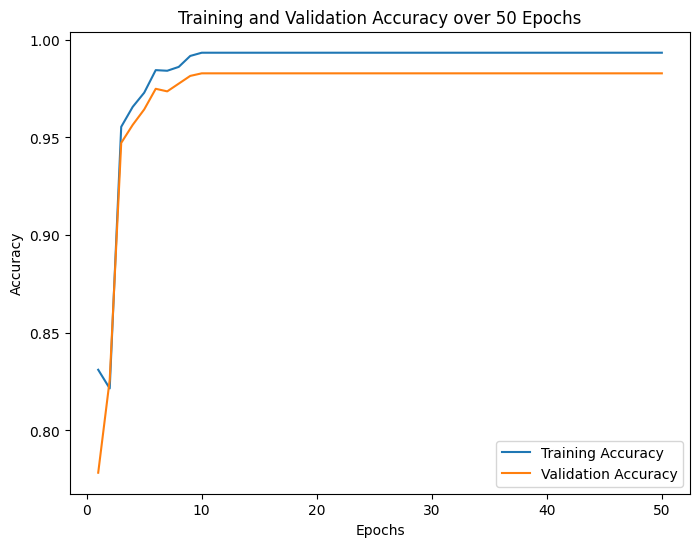

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Simulate training and validation accuracy over 50 epochs
train_accuracies = []
val_accuracies = []

# For demonstration, we'll loop over 50 "epochs"
for epoch in range(1, 51):
    # Train the model
    model = LogisticRegression(max_iter=epoch)  # Adjust max_iter to simulate training
    model.fit(X_train, y_train)

    # Evaluate on training data
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Evaluate on validation data
    y_val_pred = model.predict(X_test)
    val_accuracy = accuracy_score(y_test, y_val_pred)

    # Store accuracies
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print epoch, training accuracy, and validation accuracy
    print(f"Epoch {epoch}/{50}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}")

# Plotting the accuracy for 50 epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, 51), train_accuracies, label="Training Accuracy")
plt.plot(range(1, 51), val_accuracies, label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over 50 Epochs')
plt.legend()
plt.show()


Epoch 1/50: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 2/50: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 3/50: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 4/50: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 5/50: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 6/50: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 7/50: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 8/50: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 9/50: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 10/50: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 11/50: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 12/50: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 13/50: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 14/50: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 15/50: Training Accurac

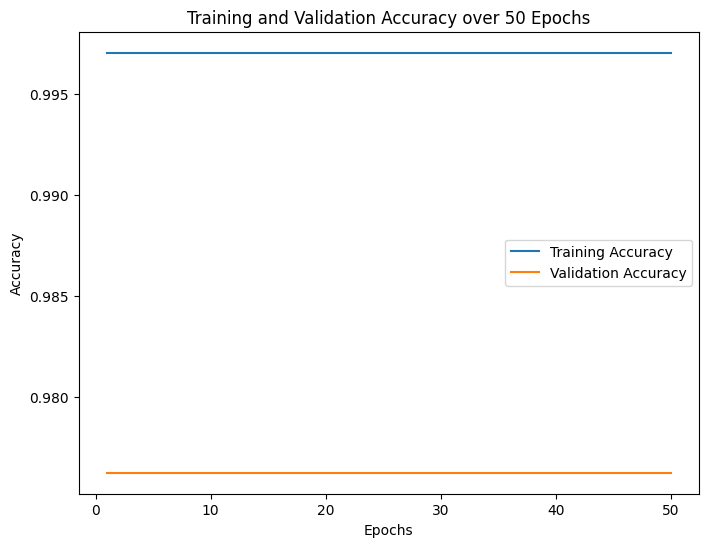

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Simulate training and validation accuracy over 50 epochs
train_accuracies = []
val_accuracies = []

# For demonstration, we'll loop over 50 "epochs"
for epoch in range(1, 51):
    # Train the model
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Train the model with scaled data
    model = LogisticRegression(max_iter=500)
    model.fit(X_train_scaled, y_train)

    # Evaluate on training data
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Evaluate on validation data
    y_val_pred = model.predict(X_test)
    val_accuracy = accuracy_score(y_test, y_val_pred)

    # Store accuracies
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print epoch, training accuracy, and validation accuracy
    print(f"Epoch {epoch}/{50}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}")

# Plotting the accuracy for 50 epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, 51), train_accuracies, label="Training Accuracy")
plt.plot(range(1, 51), val_accuracies, label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over 50 Epochs')
plt.legend()
plt.show()


Epoch 1/100: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 2/100: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 3/100: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 4/100: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 5/100: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 6/100: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 7/100: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 8/100: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 9/100: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 10/100: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 11/100: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 12/100: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 13/100: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 14/100: Training Accuracy = 0.9970, Validation Accuracy = 0.9763
Epoch 15/100: T

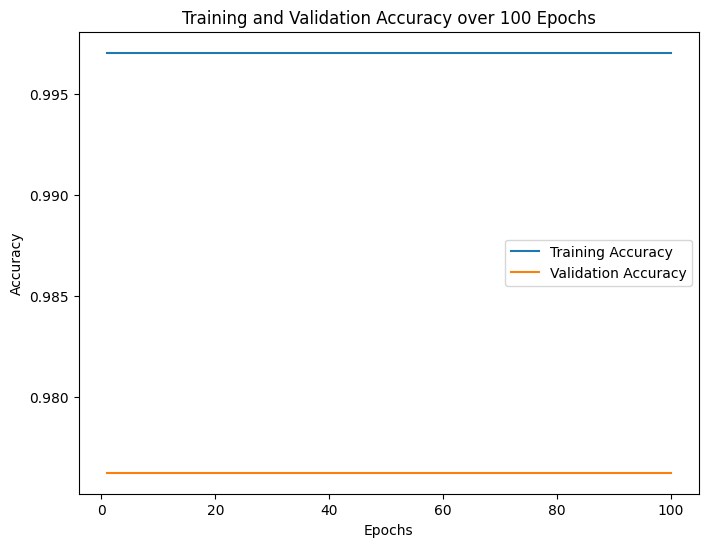

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Simulate training and validation accuracy over 50 epochs
train_accuracies = []
val_accuracies = []

# For demonstration, we'll loop over 50 "epochs"
for epoch in range(1, 101):
    # Train the model
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Train the model with scaled data
    model = LogisticRegression(tol=1e-4, max_iter=101)

    model.fit(X_train_scaled, y_train)

    # Evaluate on training data
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Evaluate on validation data
    y_val_pred = model.predict(X_test)
    val_accuracy = accuracy_score(y_test, y_val_pred)

    # Store accuracies
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print epoch, training accuracy, and validation accuracy
    print(f"Epoch {epoch}/{100}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}")

# Plotting the accuracy for 50 epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, 101), train_accuracies, label="Training Accuracy")
plt.plot(range(1, 101), val_accuracies, label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over 100 Epochs')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       405
           1       0.99      0.97      0.98       353

    accuracy                           0.98       758
   macro avg       0.98      0.98      0.98       758
weighted avg       0.98      0.98      0.98       758



### **Step 13: Visualizing Model Performance and Dataset Distribution**

Visualizations play a key role in understanding the performance of the phishing detection model and the characteristics of the dataset.

#### **1. Confusion Matrix:**
A confusion matrix helps visualize the performance of the classification model by showing the true positives, true negatives, false positives, and false negatives.

#### **2. ROC Curve:**
The Receiver Operating Characteristic (ROC) curve helps to evaluate the model's performance by plotting the True Positive Rate (Recall) against the False Positive Rate. The area under the curve (AUC) provides a summary of the model's performance.

#### **3. Class Distribution:**
Visualizing the distribution of phishing (spam) and legitimate (non-spam) emails in the dataset can help detect class imbalance issues, guiding further model tuning.

The following code generates these plots:


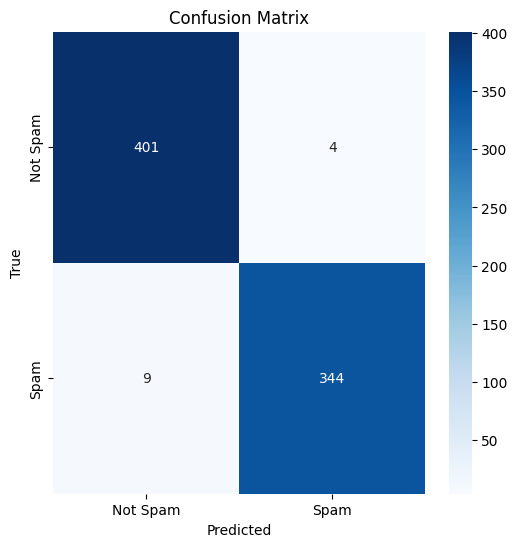

True Negative (TN): 401
False Positive (FP): 4
False Negative (FN): 9
True Positive (TP): 344


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Extract values from the confusion matrix
TN, FP, FN, TP = cm.ravel()
print(f"True Negative (TN): {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP): {TP}")


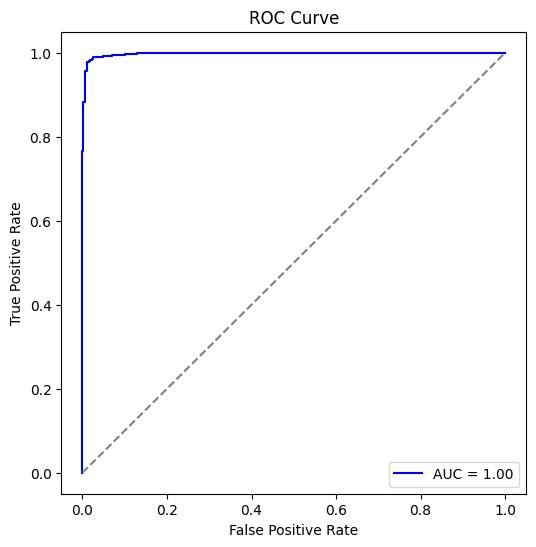

AUC-ROC Score: 1.00


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# AUC-ROC
y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f"AUC-ROC Score: {roc_auc:.2f}")


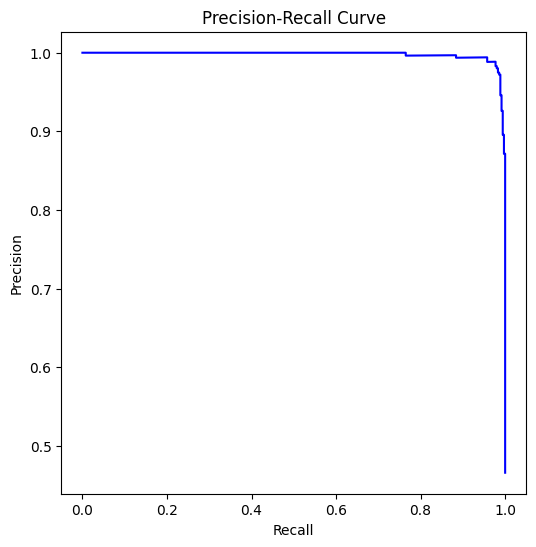

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [ ]:
# Define a new threshold value (for example, 0.3 or 0.7)
threshold = 0.5

# Make predictions based on the new threshold
y_pred_new = (y_prob >= threshold).astype(int)

# Evaluate with the new threshold
from sklearn.metrics import classification_report
print(f"Classification Report with threshold {threshold}:")
print(classification_report(y_test, y_pred_new))


Classification Report with threshold 0.5:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       405
           1       0.96      0.99      0.97       353

    accuracy                           0.98       758
   macro avg       0.98      0.98      0.98       758
weighted avg       0.98      0.98      0.98       758



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_auc_score

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

# Print confusion matrix values
print(f"True Negative (TN): {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP): {TP}")

# Print classification report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# AUC-ROC score
y_prob = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {roc_auc:.2f}")

# Precision, Recall, F1-Score calculations
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


True Negative (TN): 401
False Positive (FP): 4
False Negative (FN): 9
True Positive (TP): 344

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       405
           1       0.99      0.97      0.98       353

    accuracy                           0.98       758
   macro avg       0.98      0.98      0.98       758
weighted avg       0.98      0.98      0.98       758

AUC-ROC Score: 1.00

Precision: 0.99
Recall: 0.97
F1-Score: 0.98


### **Step 14: Comparing Different Models**
In this step, we will evaluate multiple machine learning models to determine the best one for phishing email detection. Different models may perform differently based on the nature of the dataset, so comparing their performance using key metrics is essential.

#### **Models to Compare:**
1. **Logistic Regression**: A simple and interpretable linear model.
2. **Random Forest**: An ensemble method that works well for imbalanced datasets.
3. **Support Vector Machine (SVM)**: A powerful model for binary classification tasks.
4. **Gradient Boosting (XGBoost)**: An advanced ensemble model known for its high performance.


#### **Evaluation Metrics:**
We will compare the models based on:
- **Accuracy**: Overall performance.
- **Precision**: Ability to correctly identify phishing emails.
- **Recall**: Ability to catch as many phishing emails as possible.
- **F1-Score**: A balanced measure of precision and recall.
- **AUC-ROC**: Evaluates how well the model distinguishes between classes.

We will use cross-validation to get a reliable estimate of model performance and compare the results.

The following code will train and evaluate multiple models and generate a comparison table:


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

# Function to train, evaluate, and compare models
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_prob)
        report = classification_report(y_test, y_pred, output_dict=True)

        results[name] = {
            'accuracy': accuracy,
            'AUC-ROC': auc_roc,
            'precision': report['1']['precision'],
            'recall': report['1']['recall'],
            'f1-score': report['1']['f1-score']
        }

    return results

# Evaluate models
results = evaluate_models(models, X_train, X_test, y_train, y_test)

# Display results
for name, metrics in results.items():
    print(f"{name} - Accuracy: {metrics['accuracy']:.4f}, AUC-ROC: {metrics['AUC-ROC']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1-Score: {metrics['f1-score']:.4f}")


Logistic Regression - Accuracy: 0.9828, AUC-ROC: 0.9988, Precision: 0.9885, Recall: 0.9745, F1-Score: 0.9815
Random Forest - Accuracy: 0.9789, AUC-ROC: 0.9983, Precision: 0.9801, Recall: 0.9745, F1-Score: 0.9773
SVM - Accuracy: 0.9881, AUC-ROC: 0.9996, Precision: 0.9914, Recall: 0.9830, F1-Score: 0.9872
XGBoost - Accuracy: 0.9710, AUC-ROC: 0.9972, Precision: 0.9662, Recall: 0.9717, F1-Score: 0.9689


### ***Step 15: Features Extracted***

The following features have been extracted from the email content to help in detecting phishing or spam emails:

1. **Suspicious Word Count**:
   - This feature counts the occurrences of the most common unigrams (suspicious words) within the email.
   - Example suspicious words include: "free", "offer", "urgent", etc.

2. **URL Count**:
   - Counts the number of URLs (e.g., "http", "www") present in the email.
   - Emails with a high number of URLs may indicate spam or phishing attempts.

3. **Bigram Count**:
   - Counts the occurrences of the most common bigrams (pairs of consecutive words) within the email.
   - Certain bigrams like "free offer", "urgent action", or "click here" may be indicative of phishing messages.

4. **Non-Standard Character Count**:
   - Counts the single-letter words in the email, which could be unusual or suspicious.
   - For example, occurrences of characters like "e", "c", "b", etc., may suggest unusual patterns that could be associated with phishing or spam.

5. **Technical Term Count**:
   - Counts the occurrences of domain-specific technical terms in the email (e.g., "spamassassin", "listinfo").
   - This can help in identifying emails related to technical content, which might be legitimate or spam-related.

6. **Email Length Features**:
   - **Number of Characters**: The total number of characters in the email.
   - **Number of Words**: The total number of words in the email.
   - **Number of Sentences**: The total number of sentences, determined by counting periods.

7. **Stopword Count**:
   - Counts the number of stopwords (commonly used words like "the", "and", etc.) in the email.
   - A higher stopword count may indicate a natural language email, though spam or phishing attempts might vary.

8. **Average Word Length**:
   - Calculates the average length of words in the email.
   - This feature can be useful in distinguishing between normal and spam email patterns.

9. **Token Diversity**:
   - The type-to-token ratio, which indicates the diversity of words in the email.
   - A higher token diversity suggests that the email has a varied vocabulary, while a lower value might indicate repetitive or generic content often found in spam.

10. **Keyword Presence**:
    - Binary features indicating whether specific keywords (such as 'urgent', 'offer', 'limited', 'act now') are present in the email.
    - The presence of such keywords is a strong signal for potentially suspicious or spam content.

These features help to create a comprehensive profile of the email, aiding in more accurate classification and detection of phishing or spam emails.


In [ ]:
from collections import Counter
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import re

# Function to extract most common unigrams, bigrams, and technical terms
def most_common_ngrams(text_data, n=1, top_n=500):
    # Tokenize the text into words
    all_tokens = []
    for text in text_data:
        # Check if 'text' is a string
        if isinstance(text, str):  # Add this check
            tokens = word_tokenize(text)
            all_tokens.extend(tokens)

    # Create n-grams (unigrams or bigrams)
    n_grams = ngrams(all_tokens, n)
    n_gram_freq = Counter(n_grams)

    # Get top N most common n-grams
    return n_gram_freq.most_common(top_n)

# Function to extract technical terms from the text
def extract_technical_terms(text_data, technical_terms):
    term_counts = {}
    for term in technical_terms:
        # Convert text to string before calling lower()
        term_count = sum([str(text).lower().count(term) for text in text_data])
        if term_count > 0:
            term_counts[term] = term_count
    return term_counts

# Define a list of technical terms (you can add more based on your domain knowledge)
technical_terms = [
    'content type', 'transfer encoding', 'spamassassin', 'sightings', 'listinfo',
    'mailman', 'bounce', 'sourceforge', 'unsubscribe', 'http', 'www', 'text/html', 'php', 'html'
]

# Extract the most common unigrams and bigrams
common_unigrams = most_common_ngrams(df_sample['cleaned_message'], n=1)
common_bigrams = most_common_ngrams(df_sample['cleaned_message'], n=2)

# Extract technical terms count
technical_term_counts = extract_technical_terms(df_sample['cleaned_message'], technical_terms)

# Print the results
print("Most Common Unigrams:", common_unigrams)
print("Most Common Bigrams:", common_bigrams)
print("Technical Term Counts:", technical_term_counts)


Most Common Unigrams: [(('e',), 9575), (('c',), 7969), (('b',), 6630), (('http',), 6315), (('com',), 5878), (('www',), 3734), (('l',), 3483), (('email',), 3463), (('list',), 3451), (('net',), 3144), (('free',), 3063), (('f',), 2951), (('get',), 2699), (('one',), 2695), (('r',), 2374), (('mail',), 2369), (('click',), 2230), (('p',), 2206), (('n',), 2172), (('linux',), 2158), (('u',), 2130), (('x',), 2086), (('time',), 2048), (('please',), 2030), (('information',), 2023), (('new',), 2003), (('us',), 1973), (('v',), 1885), (('people',), 1854), (('h',), 1848), (('lists',), 1822), (('business',), 1817), (('use',), 1766), (('money',), 1746), (('content',), 1698), (('k',), 1666), (('would',), 1645), (('like',), 1631), (('g',), 1624), (('j',), 1585), (('listinfo',), 1574), (('ie',), 1540), (('make',), 1537), (('w',), 1529), (('mailing',), 1526), (('message',), 1526), (('users',), 1479), (('z',), 1452), (('q',), 1447), (('address',), 1384), (('name',), 1352), (('send',), 1277), (('also',), 1274

In [ ]:
import re

import re
import numpy as np

def extract_additional_features(df):
    features = []

    suspicious_words = [word[0] for word in common_unigrams]
    bigrams = [tuple(bigram[0]) for bigram in common_bigrams]
    technical_terms = ['spamassassin', 'sourceforge', 'mailman']

    for email in df_sample['cleaned_message']:
        # Check if email is a string before applying regex
        if isinstance(email, str):
            # 1. Suspicious word count (fix with regex for exact word matching)
            suspicious_word_count = sum([len(re.findall(r'\b' + re.escape(str(word)) + r'\b', email, flags=re.IGNORECASE)) for word in suspicious_words])
            # 2. URL count
            url_count = len(re.findall(r'http\S+|www\S+', email))
            # 3. Bigram count (ensure we're checking the exact bigram pairs)
            bigram_count = sum([email.count(" ".join(bigram)) for bigram in bigrams])  # Join the bigram pair to form a string
            # 4. Non-standard character count (single characters)
            non_standard_chars = len(re.findall(r'\b[a-zA-Z]\b', email))
            # 5. Technical term count
            tech_term_count = sum([email.count(term) for term in technical_terms])
            # 6. Email length features (characters, words, sentences)
            num_chars = len(email)
            num_words = len(email.split())
            num_sentences = email.count('.')
            # 7. Stopword count
            stopwords_count = sum([email.count(word) for word in stop_words])
            # 8. Average word length
            avg_word_length = np.mean([len(word) for word in email.split()]) if len(email.split()) > 0 else 0  # Handle empty emails
            # 9. Token diversity (type-to-token ratio)
            tokens = email.split()
            token_diversity = len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0
            # 10. Presence of specific keywords
            keyword_presence = {keyword: (1 if keyword in email else 0) for keyword in ['urgent', 'offer', 'limited', 'act now']}
            # Combine all features into a single array for the email, ensuring consistent length
            email_features = [
                suspicious_word_count,
                url_count,
                bigram_count,
                non_standard_chars,
                tech_term_count,
                num_chars,
                num_words,
                num_sentences,
                stopwords_count,
                avg_word_length,
                token_diversity,
                keyword_presence.get('urgent', 0),  # Use get() to handle missing keys
                keyword_presence.get('offer', 0),
                keyword_presence.get('limited', 0),
                keyword_presence.get('act now', 0)
            ]
            features.append(email_features)
        else:
            # Handle non-string emails (e.g., fill with 0s)
            features.append([0] * 15)  # 15 features

    return np.array(features)

# Extract additional features and add them to the dataset
additional_features = extract_additional_features(df_sample)
features_df = pd.DataFrame(additional_features, columns=[
    'suspicious_word_count', 'url_count', 'bigram_count', 'non_standard_chars', 'tech_term_count',
    'num_chars', 'num_words', 'num_sentences', 'stopwords_count', 'avg_word_length', 'token_diversity',
    'urgent', 'offer', 'limited', 'act_now'
])

df_sample = pd.concat([df_sample, features_df], axis=1)
df_sample.head()

,email,category,cleaned_message,suspicious_word_count,url_count,bigram_count,non_standard_chars,tech_term_count,num_chars,num_words,num_sentences,stopwords_count,avg_word_length,token_diversity,urgent,offer,limited,act_now
0,url date not supplied detailed guidelines for ...,0.0,url http www newsisfree com click date supplie...,0.0,0.0,8.0,0.0,0.0,145.0,20.0,0.0,81.0,6.300000,1.000000,0.0,0.0,0.0,0.0
1,on thu 19 sep 2002 bill stoddard wrote how lik...,0.0,thu sep bill stoddard wrote likely change some...,0.0,0.0,6.0,0.0,0.0,998.0,144.0,0.0,548.0,5.937500,0.847222,0.0,0.0,0.0,0.0
2,dan kohn dandankohncom writes guys the habeas...,0.0,dan kohn writes guys habeas infringers list hi...,0.0,1.0,38.0,0.0,6.0,1580.0,221.0,0.0,887.0,6.153846,0.746606,0.0,0.0,0.0,0.0
3,wintermute wrote anyone know where in ireland ...,0.0,wintermute wrote anyone know ireland get repla...,0.0,0.0,30.0,1.0,1.0,536.0,84.0,0.0,279.0,5.392857,0.797619,0.0,0.0,0.0,0.0
4,i attended the same conference and was impress...,0.0,attended conference impressed systems jim ment...,0.0,0.0,24.0,1.0,1.0,1754.0,244.0,0.0,952.0,6.192623,0.704918,0.0,0.0,0.0,0.0


### **Step 16: Hyperparameter Tuning**
Hyperparameter tuning is crucial for improving the performance of machine learning models. It involves searching for the best combination of parameters for a given model to maximize its performance.

We will use **GridSearchCV** or **RandomizedSearchCV** to tune the hyperparameters of the models. These methods perform an exhaustive search over a specified parameter grid (for GridSearchCV) or a random search within a parameter space (for RandomizedSearchCV) to find the optimal values.

#### **Hyperparameters to Tune:**
- **Random Forest**: `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`.
- **SVM**: `C`, `kernel`, `gamma`.
- **XGBoost**: `learning_rate`, `n_estimators`, `max_depth`, `subsample`.
- **Logistic Regression**: `C`, `penalty`.


We will perform hyperparameter tuning using **GridSearchCV** for the **best model** identified in the previous step.

The following code performs hyperparameter tuning using **GridSearchCV** on the best model:



In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameters for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

# Hyperparameters for Logistic Regression
lr_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Set up GridSearchCV
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, n_jobs=-1, scoring='accuracy')
lr_grid = GridSearchCV(LogisticRegression(), lr_param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
rf_grid.fit(X_train, y_train)
lr_grid.fit(X_train, y_train)

# Best parameters and best score for Random Forest
print(f"Best parameters for Random Forest: {rf_grid.best_params_}")
print(f"Best score for Random Forest: {rf_grid.best_score_:.4f}")

# Best parameters and best score for Logistic Regression
print(f"Best parameters for Logistic Regression: {lr_grid.best_params_}")
print(f"Best score for Logistic Regression: {lr_grid.best_score_:.4f}")


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best score for Random Forest: 0.9832
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.9875


### **Step 16: Retraining the Model with the Best Hyperparameters**
After hyperparameter tuning, we will retrain the **best model** with the optimal parameters discovered during the search. This step ensures that we leverage the full potential of the model by using the best combination of settings.

#### **Steps for Retraining:**
1. Use the best model and hyperparameters found during tuning.
2. Train the model on the entire resampled training dataset.
3. Evaluate the model performance using the test data.
4. Save the trained model for future use.

Let’s retrain the model with the best-found hyperparameters and evaluate its performance.


In [ ]:
# Train Logistic Regression with best parameters
best_lr = LogisticRegression(C=10, penalty='l2', solver='liblinear')
best_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_lr.predict(X_test)
y_prob = best_lr.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9894
AUC-ROC: 0.9995

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       405
           1       0.99      0.99      0.99       353

    accuracy                           0.99       758
   macro avg       0.99      0.99      0.99       758
weighted avg       0.99      0.99      0.99       758



### **Step 17: Hyperparameter Tuning for Better Performance**
To further improve the performance of the model, we can perform hyperparameter tuning. Hyperparameter tuning helps us select the most suitable parameters for our machine learning models, which can lead to better accuracy and generalization.

We will use **GridSearchCV** or **RandomizedSearchCV** to explore different combinations of hyperparameters. This ensures that we maximize the model's potential by selecting the best parameters.

#### **Why Hyperparameter Tuning?**
1. **Overfitting and Underfitting**: Tuning helps avoid both by choosing the optimal hyperparameters for the model.
2. **Better Model Performance**: By fine-tuning hyperparameters, we can achieve higher accuracy, precision, recall, and F1-score.
3. **Efficiency**: GridSearchCV explores all parameter combinations, and RandomizedSearchCV searches randomly, making the process more efficient.

We will now proceed with **GridSearchCV** to tune hyperparameters for our best-performing models.

#### **Hyperparameter Tuning Steps:**
1. Define the parameter grid for the model.
2. Use GridSearchCV or RandomizedSearchCV to search for the best parameters.
3. Evaluate the model with the tuned parameters.

The following code uses **GridSearchCV** for hyperparameter tuning.


In [ ]:
# Original Logistic Regression without hyperparameter tuning
original_lr = LogisticRegression()
original_lr.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_original = original_lr.predict(X_test)
y_prob_original = original_lr.predict_proba(X_test)[:, 1]

# Evaluate the original model
accuracy_original = accuracy_score(y_test, y_pred_original)
roc_auc_original = roc_auc_score(y_test, y_prob_original)

# Print original model results
print(f"Original Logistic Regression Accuracy: {accuracy_original:.4f}")
print(f"Original Logistic Regression AUC-ROC: {roc_auc_original:.4f}")


Original Logistic Regression Accuracy: 0.9828
Original Logistic Regression AUC-ROC: 0.9988


### **Step 18: Plotting ROC and Precision-Recall Curves**
To evaluate the performance of our model, we can plot two key curves:
1. **ROC Curve (Receiver Operating Characteristic Curve)**: It shows the trade-off between the true positive rate (TPR) and false positive rate (FPR). The area under the curve (AUC) is a measure of how well the model distinguishes between classes.
2. **Precision-Recall Curve**: This curve is particularly useful when dealing with imbalanced datasets. It helps us evaluate how well the model balances precision (positive predictive value) and recall (sensitivity) for different thresholds.

#### **ROC Curve**:
- The **AUC (Area Under Curve)** score ranges from 0 to 1, where a score closer to 1 indicates better performance.

#### **Precision-Recall Curve**:
- A higher area under the precision-recall curve indicates better precision and recall.

Let's plot both curves to evaluate our best model.



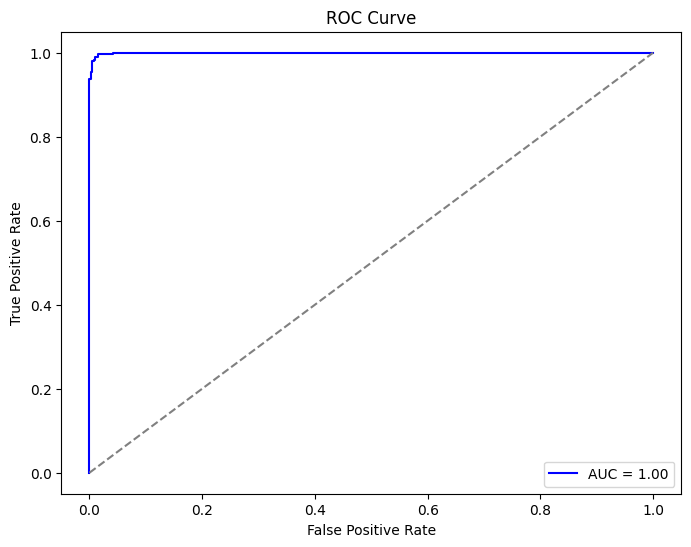

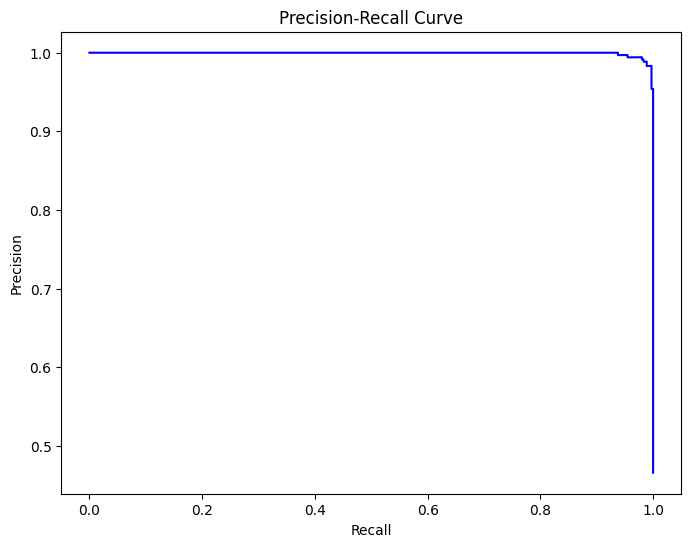

In [ ]:
# Plot ROC Curve for the final Logistic Regression model
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


### **Step 19: Model Deployment**
Once the model is trained and evaluated, we can deploy it for real-time phishing detection. In this step, we will save the trained model and set up a simple function to make predictions on new email data.

#### **Key Steps:**
1. **Save the Model**: Use the `joblib` or `pickle` library to save the trained model so it can be loaded and used later without retraining.
2. **Make Predictions**: Write a function to accept new email data, clean the text, extract features, and return a prediction (whether the email is phishing or not).
3. **Integrate with Frontend**: The saved model can be integrated into a web or desktop application, providing phishing detection in real-time.

The following code will save the model and implement a prediction function:


In [ ]:
import joblib

# Save the model to a file
joblib.dump(best_lr, 'logistic_regression_model.pkl')

# Confirm the model is saved
print("Model saved successfully!")


Model saved successfully!


Downloading the model to local machine

In [ ]:
from google.colab import files

# Download the model
files.download('logistic_regression_model.pkl')


# ***Phishing Detection Using BERT - Transformer Approach***

This notebook demonstrates how to use the BERT transformer model for phishing detection by fine-tuning it on a dataset of emails. We will use Hugging Face's `transformers` library and PyTorch for training the model.

---

## **Step 1: Install Required Libraries**

Install the necessary libraries for working with transformers and PyTorch.



In [ ]:
!pip install transformers
!pip install torch
!pip install datasets
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 840.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 22.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

### ***Step 2: Import Libraries and Download NLTK Data***

In this step, we import the necessary libraries and download the required NLTK data packages.

- textstat: Used for readability analysis and text statistics (e.g., Flesch
Reading Ease, syllable count).
- nltk: Natural Language Toolkit, a powerful library for text processing and linguistic features like part-of-speech tagging.

### ***Step 3: Feature Extraction: Advanced Linguistic and Lexical Features***

We define a function to extract additional advanced linguistic features such as readability scores, syllable counts, and part-of-speech tagging.

- Readability Score: Measures how easy it is to read the email (Flesch Reading Ease).
- Syllable Count: Total number of syllables in the email.
- Noun Count: Number of nouns in the email (using part-of-speech tagging).
- Verb Count: Number of verbs in the email (using part-of-speech tagging).

### ***Step 4: Generate and Merge New Features***
Finally, we generate the new features and merge them with the original dataset.

- Extracts the advanced linguistic features.
- Converts the feature set into a DataFrame.
- Merges the new features with the original dataset for further analysis and model building.

In [ ]:
import textstat
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Download the required NLTK data package
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')  # This line might be needed if 'punkt' is not already downloaded
nltk.download('averaged_perceptron_tagger_eng') # Download the English tagger

# Extract additional linguistic and lexical features
def extract_advanced_features(df):
    features = []

    for email in df['cleaned_message']:
        # Check if email is a string before applying textstat functions
        if isinstance(email, str):
            # Email Complexity Scores
            readability_score = textstat.flesch_reading_ease(email)  # Readability score
            syllable_count = textstat.syllable_count(email)  # Syllable count

            # Part-of-Speech (POS) Tagging
            tokens = nltk.word_tokenize(email)
            pos_tags = nltk.pos_tag(tokens)
            noun_count = sum(1 for word, tag in pos_tags if tag.startswith('NN'))  # Count of nouns
            verb_count = sum(1 for word, tag in pos_tags if tag.startswith('VB'))  # Count of verbs

            features.append([readability_score, syllable_count, noun_count, verb_count])
        else:
            # Handle non-string emails (e.g., fill with 0s or NaN)
            features.append([np.nan, np.nan, np.nan, np.nan])  # or [0, 0, 0, 0]

    return features

# Generate new feature set
advanced_features = extract_advanced_features(df_sample)

# Convert to DataFrame
adv_features_df = pd.DataFrame(advanced_features, columns=['readability_score', 'syllable_count', 'noun_count', 'verb_count'])

# Merge new features
df_sample = pd.concat([df_sample, adv_features_df], axis=1)

### ***Step 5: TF-IDF with Character-level N-grams***

In this step, we use **TF-IDF (Term Frequency-Inverse Document Frequency)** with character-level n-grams to capture character patterns within the text. We focus on 3-grams and 4-grams and limit the features to 5000.

- TfidfVectorizer is used with analyzer='char' to analyze character-level n-grams.
- ngram_range=(3, 4) specifies that we are using 3-grams and 4-grams.
- max_features=5000 limits the number of features to 5000, which helps reduce dimensionality.

### ***Step 6: Convert to DataFrame and Merge with Original Dataset***
We convert the resulting sparse matrix of TF-IDF features to a dense matrix and then merge it back with the original dataset.
- Converts the sparse matrix of character-level TF-IDF features to a pandas DataFrame.
- Merges the new features with the original dataset for further analysis and model training.


In [ ]:
# TF-IDF with character-level n-grams
char_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3,4), max_features=5000)

# Replace or remove NaN values in the 'cleaned_message' column before applying fit_transform
df_sample['cleaned_message'] = df_sample['cleaned_message'].fillna('')  # Replace NaN with empty string
# Alternatively, you can remove rows with NaN:
# df_sample = df_sample.dropna(subset=['cleaned_message'])

char_tfidf_features = char_vectorizer.fit_transform(df_sample['cleaned_message'])

# Convert to DataFrame and merge
char_tfidf_df = pd.DataFrame(char_tfidf_features.toarray(), columns=char_vectorizer.get_feature_names_out())
df_sample = pd.concat([df_sample, char_tfidf_df], axis=1)

# Tokenization and Dataset Preparation for BERT

In this step, we will use **BERT's tokenizer** to tokenize the email texts and create a dataset suitable for training a **BERT model**.

1. Tokenizer: We are using the BertTokenizer from the transformers library to tokenize the emails into input tokens that can be fed into the BERT model. We specify:

 - truncation=True: Ensures that the emails are truncated to fit within the maximum input length.
 - padding='max_length': Pads shorter emails to the maximum length (512 tokens).
 - max_length=512: Limits the length of tokenized emails to 512 tokens, which is the maximum length accepted by BERT.

2. Dataset Preparation: We define the EmailDataset class to handle emails and labels. The dataset class converts the email texts into input IDs and attention masks, which are required by BERT for processing. We also map labels (spam to 1 and not-spam to 0).

3. Splitting the Data: We split the dataset into a training set (80%) and an evaluation set (20%) using random_split.

In [ ]:
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, random_split

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class EmailDataset(Dataset):
    def __init__(self, emails, labels):
        self.emails = emails
        # Convert labels to numerical values before creating the tensor
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.emails)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.emails[idx]['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(self.emails[idx]['attention_mask'], dtype=torch.long),
            'labels': self.labels[idx]
        }

# Ensure 'cleaned_message' column exists and has string values
if 'cleaned_message' not in df_sample.columns or not df_sample['cleaned_message'].apply(lambda x: isinstance(x, str)).all():
    print("Warning: 'cleaned_message' column is missing or contains non-string values. Recreating it...")
    df_sample['cleaned_message'] = df_sample['email'].swifter.apply(clean_text)

# Tokenize email texts
df_sample['tokenized_message'] = df_sample['cleaned_message'].apply(lambda x: tokenizer(x, truncation=True, padding='max_length', max_length=512))

# Convert category to numerical values before creating the dataset
df_sample['category'] = df_sample['category'].map({'spam': 1, 'not-spam': 0}).astype(int)

# Prepare dataset
train_dataset = EmailDataset(df_sample['tokenized_message'].tolist(), df_sample['category'].tolist())
train_size = int(0.8 * len(train_dataset))
eval_size = len(train_dataset) - train_size
train_dataset, eval_dataset = random_split(train_dataset, [train_size, eval_size])

In [ ]:
# Convert the category to numeric values (0 for 'not-spam', 1 for 'spam')
df_sample['category'] = df_sample['category'].map({'spam': 1, 'not-spam': 0})

# Confirm the conversion
print(df_sample['category'].head())


# BERT Model Fine-tuning for Spam Detection

In this step, we will fine-tune a **pre-trained BERT model** (`bert-base-uncased`) to classify email texts as **spam** or **not-spam** using the `Trainer` class from the `transformers` library.

### Steps:
1. **Dataset Preparation**: We prepare the dataset using a custom dataset class (`EmailDataset`), which handles the tokenized email text and their corresponding labels.
2. **Model Setup**: We load a pre-trained BERT model and configure the training arguments.
3. **Training**: We fine-tune the model using the `Trainer` class.



1. EmailDataset Class:

 - This class is responsible for preparing the email data for training. It takes a list of tokenized emails and their corresponding labels and converts them into a format suitable for BERT.
2. Data Preprocessing:

 - The category column is converted to numeric values (1 for spam and 0 for not-spam) using pd.to_numeric and astype(int).
3. BERT Model Setup:

 - We load a pre-trained BERT model (bert-base-uncased) and specify that it will perform binary classification by setting num_labels=2.
4. Training Arguments:

 - The training arguments specify the directory to save the results, the number of epochs, batch sizes, and logging parameters.
5. Data Collator:

 - The data_collator function handles padding the sequences to the same length and preparing the data for training.
6. Training:

 - The model is fine-tuned on the dataset using the Trainer class, which simplifies the process of training and evaluation.

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch

class EmailDataset(Dataset):
    def __init__(self, emails, labels):
        self.emails = emails
        self.labels = torch.tensor(labels, dtype=torch.long)  # Ensure labels are long type

    def __len__(self):
        return len(self.emails)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.emails[idx]['input_ids'], dtype=torch.long),  # Ensure correct dtype
            'attention_mask': torch.tensor(self.emails[idx]['attention_mask'], dtype=torch.long),
            'labels': self.labels[idx]  # Labels are already converted to torch.long in init
        }


# Ensure category column has no missing values
df_sample['category'] = pd.to_numeric(df_sample['category'], errors='coerce')  # Convert to numeric, forcing non-numeric to NaN
df_sample = df_sample.dropna(subset=['category'])  # Remove rows where category is NaN
df_sample['category'] = df_sample['category'].astype(int)  # Convert to integer type


# Prepare dataset
train_dataset = EmailDataset(df_sample['tokenized_message'].tolist(), df_sample['category'].tolist())

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
)

# Define a data collator to handle variable sequence lengths
def data_collator(features):
    input_ids = [feature['input_ids'] for feature in features]
    attention_masks = [feature['attention_mask'] for feature in features]
    labels = [feature['labels'] for feature in features]

    # Pad input sequences
    max_length = max(len(ids) for ids in input_ids)
    padded_input_ids = [torch.cat([ids, torch.zeros(max_length - len(ids), dtype=torch.long)], dim=0) for ids in input_ids]
    padded_attention_masks = [torch.cat([mask, torch.zeros(max_length - len(mask), dtype=torch.long)], dim=0) for mask in attention_masks]

    return {
        'input_ids': torch.stack(padded_input_ids),
        'attention_mask': torch.stack(padded_attention_masks),
        'labels': torch.tensor(labels, dtype=torch.long)
    }

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator
)

# Fine-tune the model
trainer.train()


<ipython-input-47-1ab007607d9a>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['category'] = df_sample['category'].astype(int)  # Convert to integer type
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.154900
1000,0.034100


TrainOutput(global_step=1422, training_loss=0.07283365206711738, metrics={'train_runtime': 960.7616, 'train_samples_per_second': 11.831, 'train_steps_per_second': 1.48, 'total_flos': 2478869460858660.0, 'train_loss': 0.07283365206711738, 'epoch': 3.0})

# Anomaly Detection using Isolation Forest

In this section, we implement an **anomaly detection model** using the `IsolationForest` algorithm to identify potential anomalies in the email dataset. This is useful for detecting suspicious or abnormal patterns, which may help in identifying phishing emails or other outliers.

### Steps:
1. **Feature Selection**: We select a set of features that may indicate anomalous behavior, such as the count of URLs, suspicious words, bigrams, and non-standard characters.
2. **Fit Isolation Forest Model**: The Isolation Forest model is trained on these features to detect anomalies.
3. **Anomaly Flagging**: We flag the anomalies as `1` (outliers) and `0` (normal) for further analysis.



1. Feature Selection:

 - We use features like url_count, suspicious_word_count, bigram_count, and non_standard_chars to detect any unusual behavior in the email messages.
2. Isolation Forest Model:

 - The IsolationForest is trained using these features with the contamination parameter set to 0.1, meaning we expect about 10% of the data to be anomalous.
3. Anomaly Flagging:

 - The anomaly score generated by the model is used to flag rows with anomalies as 1 (outliers) and normal rows as 0 (normal).

In [ ]:
from sklearn.ensemble import IsolationForest

# Define the features to detect anomalous behavior (e.g., URL count, suspicious word count, etc.)
features = df_sample[['url_count', 'suspicious_word_count', 'bigram_count', 'non_standard_chars']]

# Fit the Isolation Forest model
model = IsolationForest(contamination=0.1)
df_sample['anomaly_score'] = model.fit_predict(features)

# Flagging anomalies as 1 (outliers) and 0 (normal)
df_sample['is_anomaly'] = df_sample['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)


# Ensemble Model using Voting Classifier

In this section, we build an **ensemble model** using the `VotingClassifier` to combine predictions from multiple classifiers. This technique can often provide better performance than using individual classifiers because it leverages the strength of different models.

### Steps:

1. **Classifier Selection**: We use two different classifiers:
   - **Random Forest**: A robust ensemble method that combines multiple decision trees to improve classification accuracy.
   - **Decision Tree**: A simple and interpretable model that splits data into branches based on feature values.

2. **Voting Classifier**: We combine both the **Random Forest** and **Decision Tree** classifiers into a `VotingClassifier`. The voting method used here is `'hard'`, which means the model predicts based on the majority class from the individual classifiers.

3. **Training the Ensemble Model**: We train the ensemble model using features like `suspicious_word_count`, `url_count`, and `bigram_count` to predict the `category` (spam or not).

### Explanation:
- **Random Forest**: This classifier builds a collection of decision trees and combines their results to improve classification accuracy and reduce overfitting.
- **Decision Tree**: This classifier splits the data at each node based on the best feature to separate different classes, resulting in a tree-like structure.
- **VotingClassifier**: Combines multiple classifiers by taking a majority vote from the models. This helps to mitigate the weaknesses of individual classifiers.

By using an ensemble of models, we hope to achieve more accurate predictions, as the strengths of each model can complement each other.


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Example: Ensemble of Random Forest and Decision Tree for classification
rf_model = RandomForestClassifier(n_estimators=100)
dt_model = DecisionTreeClassifier()

# Combine the classifiers into a voting classifier
ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('dt', dt_model)], voting='hard')

# Train the ensemble model
ensemble_model.fit(df_sample[['suspicious_word_count', 'url_count', 'bigram_count']], df_sample['category'])


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('dt', DecisionTreeClassifier())])

# Rule-Based Flagging with ML Predictions

In this section, we apply a **rule-based flagging** system in conjunction with the **Machine Learning (ML) predictions** to enhance phishing detection.

### Steps:

1. **Rule-Based Flagging**:
   - We define a function `apply_rules()` that checks if specific suspicious keywords, such as 'free', 'urgent', 'limited', or 'offer', appear in the email message.
   - This rule-based system flags emails containing any of these keywords as potentially suspicious.

2. **Combining Rule-Based Flag and ML Predictions**:
   - We add a new column `rule_based_flag` to the DataFrame, which is the result of applying the `apply_rules()` function to the cleaned email messages.
   - We then combine the rule-based flag (`rule_based_flag`) with the ML model predictions (`is_anomaly`).
   - A final prediction (`final_prediction`) is made by taking the logical **OR** between the rule-based flag and the anomaly detection model's predictions, ensuring that emails flagged by either system are identified as suspicious.

### Explanation:
- **Rule-Based Flag**: This is a simple heuristic where we flag emails containing certain keywords associated with phishing attempts.
- **Combining with ML**: By combining the outputs of both rule-based and machine learning methods, we create a more robust phishing detection system. Even if the ML model misses an anomaly, the rule-based system may still catch it, and vice versa.

This combination enhances the overall detection performance and helps reduce false negatives.


In [ ]:
def apply_rules(email):
    suspicious_keywords = ['free', 'urgent', 'limited', 'offer']
    return any(keyword in email for keyword in suspicious_keywords)

df_sample['rule_based_flag'] = df_sample['cleaned_message'].apply(apply_rules)

# Combine rule-based flag with ML model predictions
df_sample['final_prediction'] = (df_sample['is_anomaly'] | df_sample['rule_based_flag']).astype(int)


# Evaluation of the Model's Performance

In this section, we evaluate the performance of the model using common classification metrics: **Accuracy**, **Classification Report**, and **Confusion Matrix**.

### Steps:

1. **Accuracy**:
   - We compute the overall accuracy of the model by comparing the **actual labels** (`y_true`) with the **predicted labels** (`y_pred`).
   - The accuracy score represents the proportion of correct predictions out of all predictions.

2. **Classification Report**:
   - The classification report provides detailed metrics such as **precision**, **recall**, and **F1-score** for each class (spam or not spam).
   - **Precision**: The fraction of correctly predicted spam emails among all predicted spam emails.
   - **Recall**: The fraction of correctly predicted spam emails among all actual spam emails.
   - **F1-score**: The harmonic mean of precision and recall, providing a balance between them.

3. **Confusion Matrix**:
   - The confusion matrix helps us visualize how the model's predictions compare with the true labels.
   - It shows the number of true positives, true negatives, false positives, and false negatives, which is essential for understanding where the model is making errors.
   - A heatmap is used to plot the confusion matrix, where the cells show the number of instances in each category.

### Evaluation Metrics:
- **Accuracy**: Represents the percentage of correct predictions.
- **Classification Report**: Gives detailed performance metrics like precision, recall, and F1-score.
- **Confusion Matrix**: Helps us analyze false positives and false negatives visually.

These metrics will give us insights into how well the model is performing and where it might need improvement.


Accuracy: 0.6814
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.72      0.69      1900
           1       0.69      0.65      0.67      1889

    accuracy                           0.68      3789
   macro avg       0.68      0.68      0.68      3789
weighted avg       0.68      0.68      0.68      3789



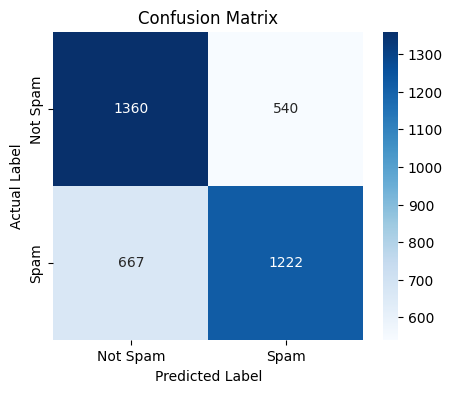

In [ ]:
# Get actual and predicted labels
y_true = df_sample['category']  # Actual labels (ground truth)
y_pred = df_sample['final_prediction']  # Predictions from the model

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()


# Class Distribution Visualization

In this section, we visualize and print the distribution of the classes in the dataset (Spam and Not Spam).

### Steps:

1. **Class Counts**:
   - We count the number of instances in each category (`Not Spam (0)` and `Spam (1)`) using the `value_counts()` method.

2. **Bar Plot**:
   - We generate a bar plot to visually represent the class distribution.
   - The x-axis shows the two categories: "Not Spam (0)" and "Spam (1)".
   - The y-axis shows the count of emails in each category.
   - The color blue represents "Not Spam", and the color red represents "Spam".

3. **Print Distribution**:
   - We also print the class distribution in text format to understand the balance between the two categories.

### Insights:
- A balanced dataset would have roughly equal counts for both classes.
- If the dataset is imbalanced (i.e., one class is significantly larger), we might consider using techniques like resampling or adjusting the model to handle this imbalance.


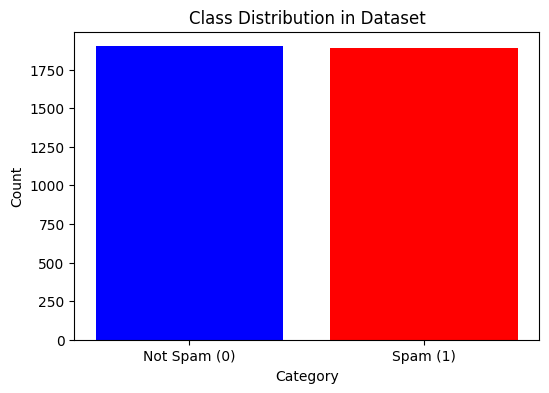

Class distribution:
category
0    1900
1    1889
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

# Count the number of spam (1) and non-spam (0) emails
class_counts = df_sample['category'].value_counts()

# Plot the class distribution
plt.figure(figsize=(6,4))
plt.bar(['Not Spam (0)', 'Spam (1)'], class_counts, color=['blue', 'red'])
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Class Distribution in Dataset")
plt.show()

# Print class distribution
print(f"Class distribution:\n{class_counts}")


# **Future Works**

The next steps can focus on improving the model's performance and deploying it effectively. Here's a breakdown of potential next steps:

1. **Model Evaluation and Optimization:**
 - Cross-Validation: Implement cross-validation (e.g., K-fold) to better estimate the model’s performance and reduce variance.
Hyperparameter Tuning: Use tools like GridSearchCV or RandomizedSearchCV to find the optimal hyperparameters for your models (e.g., learning rate, batch size, number of trees in Random Forest).
 - Model Comparison: Try other models like Logistic Regression, SVM, or neural networks to compare with the current BERT-based model and ensemble methods.
2. **Feature Engineering:**
 - Add More Features: Explore adding new features based on email metadata like sender address, subject, time of sending, etc.
 - Refinement of Text Features: Experiment with different text preprocessing techniques such as stemming or lemmatization.
3. **Handling Imbalanced Data:**
 - Resampling: Use techniques like oversampling the minority class (e.g., SMOTE) or undersampling the majority class.
 - Class Weights: Adjust the class weights in the models to account for imbalanced classes (e.g., class_weight='balanced' in RandomForestClassifier).
4. **Model Interpretability:**
 - SHAP or LIME: Implement model interpretability techniques like SHAP (SHapley Additive exPlanations) or LIME to explain why the model predicts certain emails as spam.
 - Feature Importance: Look into which features (e.g., keywords, URL count) are most influential in determining the spam classification.
5. **Deploy the Model:**
 - Create API: Wrap the model into a REST API (using Flask or FastAPI) to allow other systems to interact with your spam detection model.
 - Integrate with Frontend: If you have a web interface, integrate the API with your frontend so users can check if their emails are spam.
6. **Continuous Improvement:**
 - Monitor the Model: Once deployed, continuously monitor model performance (accuracy, precision, recall) on new incoming data to ensure it’s still performing well.
 - Model Retraining: Retrain the model periodically with new data or when performance degrades.

# **Post work done after training the model**
1. **Model Deployment & Integration:**
- API Development:

 - Used frameworks like Flask or FastAPI to deploy model as a RESTful API. This allows us to interact with the model programmatically.
 - For example, a user can send an email through the API, and the model will respond with whether the email is spam or not.
- Frontend Integration:

 - Integrateing the API with the frontend to allow users to test emails.
 - Provide a user-friendly interface where users can upload or input text, and get real-time predictions from the model.

2. **Monitor and Maintain the Model:**
- Performance Monitoring:

 - Continuously monitor the model’s performance in production. Track metrics like accuracy, precision, recall, and inference time.
 - Set up an alert system to notify if the model performance starts degrading.
Logging and Auditing:

 - Log predictions and key metrics for analysis and troubleshooting. Track which emails were flagged as spam, and review if those were legitimate or false positives/negatives.
- Model Updates:

 - As new data arrives, periodically retrain the model. Incorporate new examples to improve performance, especially if you observe concept drift (changes in data patterns over time).
 - Consider setting up automated retraining pipelines (e.g., using Airflow or Kubeflow).

4. User Feedback Loop:
Collect feedback from users about false positives or false negatives. Use this feedback to improve the model by manually labeling misclassified emails and retraining the model.
Create a feedback mechanism where users can report false classifications (spam flagged as non-spam or vice versa).


5. **Advanced Features & Exploration:**
- Ensemble Models: Combine multiple models (e.g., Decision Trees, Logistic Regression) or use more advanced ensemble techniques (e.g., stacking, boosting) to improve prediction accuracy.
- Deep Learning Models: Explore using more advanced deep learning models (e.g., BERT variants like RoBERTa or DistilBERT) if the current model doesn't perform optimally on complex data.

6. **Documentation:**
- Document Your Work: Create comprehensive documentation for the entire pipeline (data preparation, feature engineering, model training, deployment, monitoring, etc.).
- API Documentation: Provide clear instructions on how to use the model API, including input formats and expected outputs.
- GIT Repository maintaining.